In [ ]:
# Installs kneed if you don't already have it installed.
import sys
!{sys.executable} -m pip install kneed    

In [ ]:
# Imports modules which will be used throughout the code.
import pandas as pd                         
import numpy as np                          
import matplotlib                           
from matplotlib import pyplot as plt        
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats, integrate                     
from kneed import KneeLocator               
import math
from sympy.solvers import solve
from sympy import Symbol
import os
import ipywidgets as widgets

In [2]:
# Creates a user interface using the widget module.
widget_width = '900px'                                     
padding = '0px 0px 0px 4px'

text0 = widgets.Text(
    value="",
    description="Filepath or URL:",
    placeholder="Enter filepath or URL to file adding '?raw=true' to the end of any URL",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text0

text1 = widgets.Text(
    value="",
    description="Pad Voltage / V:",
    placeholder="Enter pad voltage",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text1

text2 = widgets.Text(
    value="",
    description="Resistance / $ \Omega $:",
    placeholder="Enter resistance in ohms",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text2

text3 = widgets.Text(
    value="",
    description="Thickness / $\mu$m:",
    placeholder="Enter thickness in micrometres",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text3

text6 = widgets.Text(
    value="",
    description="Filepath to save the data:",
    placeholder="eg. C:/Users/tom/dick/harry",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text6

text8 = widgets.Text(
    value="",
    description="Thickness error / $\mu$m:",
    placeholder="Enter thickness error in micrometres",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text8

# Sets the output of the user input to variables which can be used in the rest of the code.
toolbar_widget = widgets.VBox()
toolbar_widget.children = [
    text0,
    text1,
    text2,
    text3,
    text8,
    text6
    
]
#Displays the widget.
toolbar_widget

 
The datatypes of each column:
Time       float64
Voltage    float64
dtype: object


C:\Users\bluse\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
C:\Users\bluse\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10


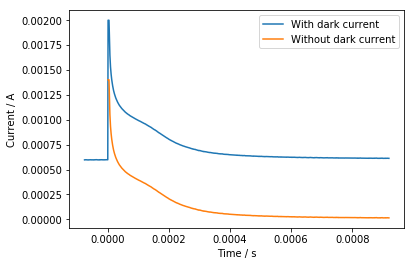

The generated polynomial regression:
 
           20             19             18             17
4.453e+65 x  - 3.117e+63 x  + 9.274e+60 x  - 1.458e+58 x 
              16             15             14             13
 + 1.105e+55 x  + 9.289e+50 x  - 9.606e+48 x  + 6.642e+45 x 
              12             11             10             9
 + 2.702e+42 x  - 8.514e+39 x  + 7.929e+36 x  - 4.522e+33 x
              8             7             6             5             4
 + 1.779e+30 x - 5.004e+26 x + 1.013e+23 x - 1.457e+19 x + 1.455e+15 x
              3             2
 - 9.673e+10 x + 4.033e+06 x - 97.34 x + 0.001592


C:\Users\bluse\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


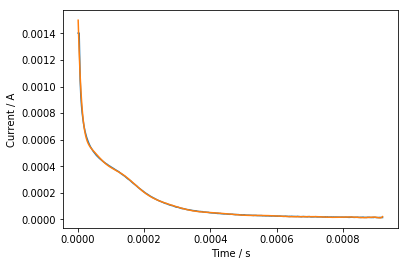

Polynomial photocharge: 1.222402018905684e-07 with an error of: 8.598436444047929e-09
 
Cumulative trapezoidal photocharge: 1.222996212993419e-07


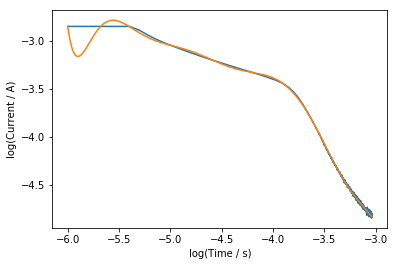

The polynomial for the double logarithmic plot:
 
        10         9         8        7             6             5
0.1654 x  + 7.068 x + 134.7 x + 1509 x + 1.098e+04 x + 5.432e+04 x
              4             3            2
 + 1.847e+05 x + 4.263e+05 x + 6.39e+05 x + 5.615e+05 x + 2.196e+05


In [37]:
# Sets variable names for the output of the user interface.
filename = text0.value
Pad_Voltage = float(text1.value)
Resistance = float(text2.value)
Thickness = float(text3.value) * 10 ** (-6)
Thickness_error = float(text8.value) * 10 ** (-6)
filepath = text6.value
# Takes output from the user imput filename and adds extra to create new files and files.
savename = str(filepath) + "/electron_plate_data.csv"
graph_savename = str(filepath) + "/Graphs"

# If the path does not yet exist on the user's PC it will be created by the code.
if not os.path.exists(graph_savename):
    os.makedirs(graph_savename)
    
# If a path for files used in the code does not yet exist they will be created.
if not os.path.exists(str(filepath) + "/Intermediate_files"):
    os.makedirs(str(filepath) + "/Intermediate_files")

# By default this reads the csv format data frame (df) ready for analysis and assumes there are no headers in the data.
# If there are headers in the data you should delete "headers = None, names = ["Time", "Current"]".
df = pd.read_csv(filename, header=None, names=["Time", "Voltage"])

# A new dataframe is created removing the first 11 points to avoid the extra information often contained early
# in the csv files. If the code doesn't work here try adding higher numbers as there may be even more unwanted
# data at the beginning. Missing a few early datapoints makes a negligible difference to the overall results.
df1 = df.drop(labels = [0,1,2,3,4,5,6,7,8,9,10,11], axis = 0)
# Drops any further Not-A-Number values just in case.
df1.dropna()

# The index of the dataframe is reset to ensure the datapoints start at 0 not at 12, etc.
df1.reset_index(drop = True, inplace = True)

# Saves the cleaned data into an intermediate file for use later.
df1.to_csv(str(filepath) + "/Intermediate_files/corrected_testdata.csv", index=False)

# Sets the data to datatype 'float64' if it isn't already in this form
df1["Time"] = df1["Time"].astype("float")           
df1["Voltage"] = df1["Voltage"].astype("float")
# Resets the index of the dataframe to avoid confusion
df1.reset_index(drop = True, inplace = True)        

# Prints the types of data to ensure we definitely don't have any non float64 data remaining. This is mainly here for 
# troubleshooting.
print(" ")
print("The datatypes of each column:")
print(df1.dtypes)

# Creates a column in the dataframe for the current by dividing each value of the pad voltage by the user provided
# resistance.
df1['Current'] = df1["Voltage"] / Resistance
# Removes any infinite values that may have been left in the code by replacing them with Not a Number (NaN) values
# and then deleting any NaN values.
df1.replace([np.inf, -np.inf], np.NaN, inplace=True)
df1.dropna()

# Creates new dataframes for data with times above and below the 0s mark. Works by reading the first corrected file and
# writing a new csv file containing no values where the first character is '-' thereby removing all negative values.
# This means we can still access the data with negative values whilst also having cleaned the initial data.
with open(str(filepath) + "/Intermediate_files/corrected_testdata.csv", 'r') as f:
    with open(str(filepath) + "/Intermediate_files/corrected_testdata_positive.csv", 'w') as g:
        with open(str(filepath) + "/Intermediate_files/correlated_testdata_negative.csv", 'w') as h:
            for row in f:
                if row[0] != '-':
                    g.write(row)
                else:
                    h.write(row)
                    
# Reads the positive and negative dataframes and creates the current values for them both.                    
df2 = pd.read_csv(str(filepath) + "/Intermediate_files/corrected_testdata_positive.csv")
df_negative = pd.read_csv(str(filepath) + "/Intermediate_files/correlated_testdata_negative.csv", header=None, names=["Time", "Voltage"])
df2['Current'] = df2["Voltage"] / Resistance
df_negative["Current"] = df_negative["Voltage"] / Resistance

# Removes any infinite values and resets the index of the positive dataframe.
df2.replace([np.inf, -np.inf], np.NaN, inplace=True)
df2.dropna(inplace = True)
df2.reset_index(drop = True, inplace = True)

# The dark current is found by taking the mean value of the current from the negative data.
dark_current = df_negative["Current"].mean()
# Each value of the current in the positive dataframe has the dark current subtracted from its value.
df2['Current'] -= dark_current
# New columns are created in the dataframe for the logarithms of time and current.
df2['Log Time'] = np.log10(df2["Time"])
df2['Log Current'] = np.log10(df2["Current"])
# Infinite values are once again removed as subtracting the dark current from some noise in the positive region leads
# to negative values being put into a logarithm which leads to an error. 
df2.replace([np.inf, -np.inf], np.NaN, inplace=True)
df2.dropna(inplace = True)

# A plot of the raw data for current against is produced including the slopes before and after the dark current
# has been subtracted and the plot is saved in the specified filepath.
plt.figure()
plt.plot(df1["Time"], df1["Current"], label = "With dark current")
plt.plot(df2["Time"], df2["Current"], label = "Without dark current")
#plt.title("Time of Flight Data")
plt.xlabel("Time / s")
plt.ylabel("Current / A")
plt.legend()
plt.savefig(str(graph_savename) + "/Raw_data" + str(Pad_Voltage) + "V.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# A polynomial regression of the raw data is generated. You can change the number of free parameters after the
# 2nd comma.
a = np.polyfit(df2["Time"], df2["Current"], 20)
b = np.poly1d(a)

# The polynomial regression is printed out as a linear equation for completeness.
print("The generated polynomial regression:")
print(" ")
print(b)

# This linspace is used to plot the polynomial regression. We can choose how many points it plots after the 
# 2nd comma.
myline = np.linspace(df2["Time"].min(), df2["Time"].max(), 1000)

# We plot the current v the time again with the polynomial regression displayed to check if the regression
# seems sensible.
plt.figure()
plt.plot(df2["Time"], df2["Current"])
plt.plot(myline, b(myline))
#plt.title("Current against Time")
plt.xlabel("Time / s")
plt.ylabel("Current / A")
plt.show()

# This function uses our polynomial regression to find an integral of the curve and finds the error in its 
# measurement using Gaussian quadrature.
photocharge, photocharge_error = integrate.quad(b, df2["Time"].min(), df2["Time"].max()) 
print("Polynomial photocharge:", photocharge, "with an error of:", photocharge_error)
print(" ")
# This function performs a cumulative trapezoidal integral approximation on the raw data without the need 
# for a polynomial.
y_int = integrate.cumtrapz(df2["Current"], df2["Time"], initial=0)
print("Cumulative trapezoidal photocharge:", y_int[-1])

# A polynomial regression of the double logarithmic data is created ready to be graphed.
f = np.polyfit(df2["Log Time"], df2["Log Current"], 10)
p = np.poly1d(f)
myline_1 = np.linspace(df2["Log Time"].min(), df2["Log Time"].max(), 1000)

# The double logarithmic plot is created.
plt.figure()
plt.plot(df2["Log Time"], df2["Log Current"])
plt.plot(myline_1, p(myline_1))
#plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time / s)")
plt.ylabel("log(Current / A)")
plt.show()

# The polynomial regression is printed in the form of a linear equation.
print("The polynomial for the double logarithmic plot:")
print(" ")
print(p)

In [4]:
# A 2nd user interface is created for selecting the cuts.
widget_width = '900px'
padding = '0px 0px 0px 4px'

text4 = widgets.Text(
    value="",
    description="Upper bound for the log time (highest magnitude):",
    placeholder="Insert a positive value and the code makes it negative",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text4

text5 = widgets.Text(
    value="",
    description="Lower bound for the log time (lowest magnitude):",
    placeholder="Insert a positive value and the code makes it negative",
    style={"description_width": "initial"},
    layout=widgets.Layout(width=widget_width, padding=padding),
)
text5

# The inputs are saved as variables to be used later in the code.
toolbar_widget = widgets.VBox()
toolbar_widget.children = [
    text5,
    text4
    
    
]
# Displays the widget.
toolbar_widget

--------------------------------------------------------------------------------------------------


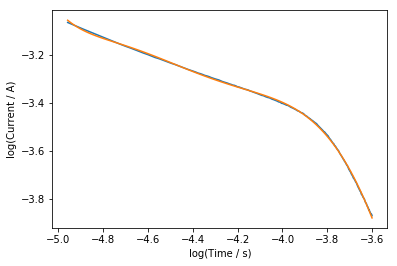

The zoomed-in polynomial for the double logarithmic plot:
 
       6         5       4        3        2
1.513 x + 37.98 x + 395 x + 2178 x + 6710 x + 1.094e+04 x + 7369
 
Log(Time) value of knee point: -3.929606529748735
 
Log(Current) value of knee point: -3.4335986399228204
None
Intercept alpha 2: -10.986997881995162
Slope alpha 2: [-1.97637126]
Intercept alpha 1: -4.797415473002523
Slope alpha 1: [-0.34773968]
The Log(Time) value of the intersection: -3.80048041509257
The Log(Current) value of the intersection: -3.47583763176823


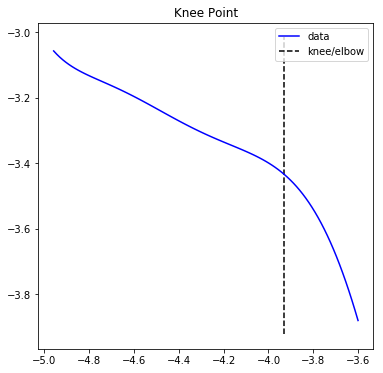

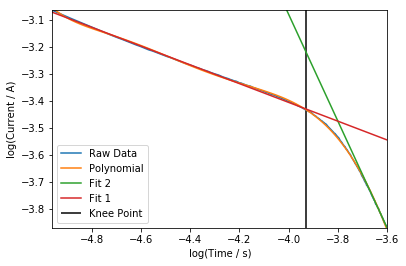

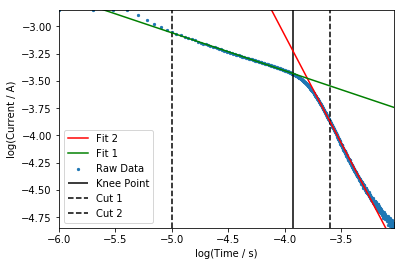

Slope of line corresponding to Alpha 1: -0.3477396794326278
Slope of line corresponding to Alpha 2: -1.976371255696622


In [38]:
# Sets the outputs of the widget to be of float64 type.
cut_max = float(text4.value)
cut_min = float(text5.value)

print("--------------------------------------------------------------------------------------------------")
# A new dataframe is created where values outside of the cuts are disgarded.
df3 = df2[df2["Log Time"] < -cut_min]
df3 = df3[df3["Log Time"] > -cut_max]

# A polynomial regression of the line between the cuts is generated. You can edit the number of free
# parameters after the 2nd comma.
f1 = np.polyfit(df3["Log Time"], df3["Log Current"], 6)
p1 = np.poly1d(f1)

# A linspace is used to allow us to plot our polynomial regression. You can edit the number of points in the
# linspace after the 2nd comma.
myline_2 = np.linspace(df3["Log Time"].min(), df3["Log Time"].max(), 100)

# Plots a double logarithmic graph of the data and of the polynomial between the two cuts.
plt.figure()
plt.plot(df3["Log Time"], df3["Log Current"])
plt.plot(myline_2, p1(myline_2))
#plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time / s)")
plt.ylabel("log(Current / A)")
plt.show()

# Prints the linear equation of the polynomial regression between the two cuts.
print("The zoomed-in polynomial for the double logarithmic plot:")
print(" ")
print(p1)

# The kneedle algorithm searches for a knee point on a concave decreasing curve. This can be editted
# to be used for a convex and an increasing curve but that is not needed here. The knee point is saved
# into a variable known as kneedle_2
kneedle_2 = KneeLocator(myline_2, p1(myline_2), S = 1.0, curve = "concave", direction = "decreasing")
# The different components of kneedle_2 are given variable names
knee_x = kneedle_2.knee
knee_y = kneedle_2.knee_y
# The values of the logarithmic time and current for the kneedle algorithm alone are printed.
print(" ")
print("Log(Time) value of knee point:", knee_x)
print(" ")

print("Log(Current) value of knee point:", knee_y)
print(kneedle_2.plot_knee())

# Values used as the nearest points to the knee on the graph are chosen arbitrarily by adding and
# subtracting +/- 0.5 * the time of flight found using the kneedle method.
t_min = knee_x + math.log10(0.5 * -knee_x)
t_max = knee_x - math.log10(0.5 * -knee_x)

# 2 dataframes are created with only the data between the cuts and t_min or t_max
df4 = df3[df3["Log Time"] > t_min]
df5 = df3[df3["Log Time"] < t_max]

# The logarithmic time and current values are saved in lists which are then reshaped ready for use in
# the linear regression algorithm.
v = np.array(df4["Log Time"].values.tolist())
w = df4["Log Current"].tolist()
x = v.reshape((-1, 1))
y = w

# A linear regression is found with the slope and intercept being printed for both of the lines used
# in the bisection.
model1 = LinearRegression().fit(x, y)
intercept_1 = model1.intercept_
slope_alpha_2 = model1.coef_
print('Intercept alpha 2:', intercept_1)
print('Slope alpha 2:', slope_alpha_2)

v = np.array(df5["Log Time"].values.tolist())
w = df5["Log Current"].tolist()
x = v.reshape((-1, 1))
y = w

model2 = LinearRegression().fit(x, y)
intercept_2 = model2.intercept_
slope_alpha_1 = model2.coef_
print('Intercept alpha 1:', intercept_2)
print('Slope alpha 1:', slope_alpha_1)

# This finds the logarithmic time and current of the bisection of the two lines and prints
# them out.
x = Symbol('x')
m = solve(intercept_1 -intercept_2 + (slope_alpha_2 - slope_alpha_1) * x, x)
print("The Log(Time) value of the intersection:", m[x])
n = intercept_1 + slope_alpha_2 * m[x]
o = n[0]
print("The Log(Current) value of the intersection:", o)

# The zoomed-in double logarithmic plot is displayed with the bisection lines.
linspace = np.linspace(df2["Log Time"].min(), df2["Log Time"].max(), num=50)
plt.figure()
plt.plot(df3["Log Time"], df3["Log Current"], label = "Raw Data")
plt.plot(myline_2, p1(myline_2), label = "Polynomial")
plt.plot(linspace, slope_alpha_2*linspace + intercept_1, label = "Fit 2")
plt.plot(linspace, slope_alpha_1*linspace + intercept_2, label = "Fit 1")
plt.vlines(knee_x, df3["Log Current"].min(), df3["Log Current"].max(), label = "Knee Point")
#plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time / s)")
plt.ylabel("log(Current / A)")
plt.xlim([df3["Log Time"].min(), df3["Log Time"].max()])
plt.ylim([df3["Log Current"].min(), df3["Log Current"].max()])
plt.legend()
plt.show()

# # The double logarithmic plot is displayed with the cuts, kneedle point, and the bisection lines.
plt.figure()
plt.scatter(df2["Log Time"], df2["Log Current"], label = "Raw Data", s = 5)
plt.plot(linspace, slope_alpha_2*linspace + intercept_1, label = "Fit 2", color = "red")
plt.plot(linspace, slope_alpha_1*linspace + intercept_2, label = "Fit 1", color = "green")
plt.vlines(knee_x, df2["Log Current"].min(), df2["Log Current"].max(), label = "Knee Point")
plt.vlines(-cut_max, df2["Log Current"].min(), df2["Log Current"].max(), label = "Cut 1", linestyles = "dashed")
plt.vlines(-cut_min, df2["Log Current"].min(), df2["Log Current"].max(), label = "Cut 2", linestyles = "dashed")
#plt.title("log(Current) against log(Time)")
plt.xlabel("log(Time / s)")
plt.ylabel("log(Current / A)")
plt.xlim([df2["Log Time"].min(), df2["Log Time"].max()])
plt.ylim([df2["Log Current"].min(), df2["Log Current"].max()])
plt.legend()
plt.savefig(str(graph_savename) + "/Scatter_doublelog" + str(Pad_Voltage) + "V.png", dpi = 300, bbox_inches = 'tight')
plt.show()

print("Slope of line corresponding to Alpha 1:", slope_alpha_1[0])
print("Slope of line corresponding to Alpha 2:", slope_alpha_2[0])

In [35]:
# A new dataframe is created including many different data columns as shown below. 
data = {'Pad Voltage/V': [Pad_Voltage], 'Resistance/Ohms': [Resistance], 'Thickness/m': [Thickness], 'Time [Fit]/microsecs': [10**6 * 10**(m[x])], 'Time [Knee]/microsecs': [10**6 * 10**(knee_x)], 'Dark current/ micro A': [10**6 * dark_current], 'Photocharge [Raw]/C': [y_int[-1]], 'Photocharge [Fit]/C': [photocharge], 'Photocharge error [Fit]/C': [photocharge_error], 'Alpha1': [1 + slope_alpha_1[0]], 'Alpha2': [-1 - slope_alpha_2[0]], 'Electric Field / (V/m)': [Pad_Voltage / Thickness], 'Mobility [Fit] / cm^2 V^-1 s^-1': [(10000 * (Thickness)**2) / (Pad_Voltage * 10**((m[x])))], 'Mobility [Knee] / cm^2 V^-1 s^-1': [(10000 * (Thickness)**2) / (Pad_Voltage * 10**((knee_x)))], 'sqrt(Electric Field) / (V/m)^0.5': [math.sqrt(Pad_Voltage / Thickness)]}  
main_dataframe = pd.DataFrame(data)

# The code checks if a prexisting file exists and appends the data to that dataframe if it does. If it does not
# exist a new csv file is created with generated headers.
if os.path.isfile(savename) == True:
    main_dataframe.to_csv(savename, mode = 'a', header = False, index = False)
else:
    main_dataframe.to_csv(savename, header = True, index = False)

[ 2.96005769e-04 -4.55098201e+00]
[ 3.25427719e-04 -4.51047394e+00]


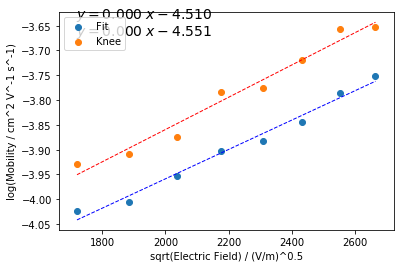

[ 0.78696538 36.51634043]


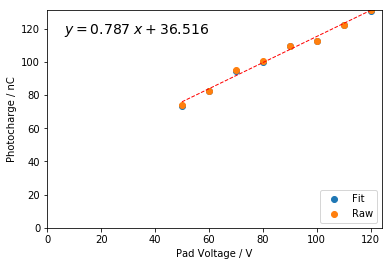

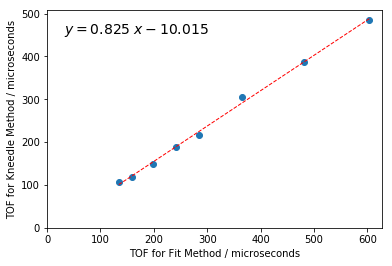

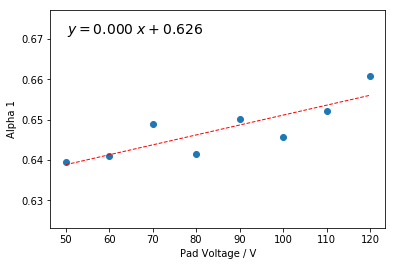

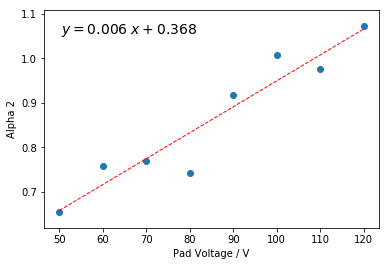

In [36]:
# A new dataframe for use in generating plots is created by reading the dataframe created above 
# and a Poole-Frenkel plot is created and saved.
new_df = pd.read_csv(savename)

# The logarithm of the mobility is found and saved into the dataframe.
new_df["LogMobilityFit"] = np.log10(new_df["Mobility [Fit] / cm^2 V^-1 s^-1"])
new_df["LogMobilityKnee"] = np.log10(new_df["Mobility [Knee] / cm^2 V^-1 s^-1"])

# A Poole-Frenkel plot is created and saved.
plt.figure()
plt.scatter(new_df["sqrt(Electric Field) / (V/m)^0.5"], np.log10(new_df["Mobility [Fit] / cm^2 V^-1 s^-1"]), label = "Fit")
plt.scatter(new_df["sqrt(Electric Field) / (V/m)^0.5"], np.log10(new_df["Mobility [Knee] / cm^2 V^-1 s^-1"]), label = "Knee")
#plt.title("log(Mobility) against Electric Field^0.5")
plt.xlabel("sqrt(Electric Field) / (V/m)^0.5")
plt.ylabel("log(Mobility / cm^2 V^-1 s^-1)")

# A linear regression is used to generate a trendline.
z = np.polyfit(new_df["sqrt(Electric Field) / (V/m)^0.5"], new_df["LogMobilityFit"], 1)
print(z)
y_hat = np.poly1d(z)(new_df["sqrt(Electric Field) / (V/m)^0.5"])

# The equation of the two linear regressions (for the knee fit and the bisection fit)
# is printed in the corner of the graph.
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(new_df["sqrt(Electric Field) / (V/m)^0.5"], y_hat, "b--", lw=1)
z = np.polyfit(new_df["sqrt(Electric Field) / (V/m)^0.5"], new_df["LogMobilityKnee"], 1)
print(z)
y_hat = np.poly1d(z)(new_df["sqrt(Electric Field) / (V/m)^0.5"])
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='bottom')
plt.plot(new_df["sqrt(Electric Field) / (V/m)^0.5"], y_hat, "r--", lw=1)
plt.legend()
plt.savefig(str(graph_savename) + "/mobility_field.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# The photocharge is converted to nC from C and then a graph of photocharge against pad voltage
# is created.
new_df["Photocharge [Fit]/nC"] = new_df["Photocharge [Fit]/C"] * 1000000000
new_df["Photocharge [Raw]/nC"] = new_df["Photocharge [Raw]/C"] * 1000000000
plt.figure()
plt.scatter(new_df["Pad Voltage/V"], new_df["Photocharge [Fit]/nC"], label = "Fit")
plt.scatter(new_df["Pad Voltage/V"], new_df["Photocharge [Raw]/nC"], label = "Raw")
#plt.title("Photocharge against Pad Voltage")
plt.xlabel("Pad Voltage / V")
plt.ylabel("Photocharge / nC")
plt.ylim([0, new_df["Photocharge [Raw]/nC"].max()])
plt.xlim(0,)

# A trendline is plotted and its equation is put in the corner of the graph.
z = np.polyfit(new_df["Pad Voltage/V"], new_df["Photocharge [Raw]/nC"], 1)
print(z)
y_hat = np.poly1d(z)(new_df["Pad Voltage/V"])
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(new_df["Pad Voltage/V"], y_hat, "r--", lw=1)
plt.legend(loc = "lower right")
plt.savefig(str(graph_savename) + "/photocharge_voltage.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# A graph of knee time v bisection time is plotted with a trendline and its equation.
plt.figure()
plt.scatter(new_df["Time [Fit]/microsecs"], new_df["Time [Knee]/microsecs"])
#plt.title("TOF of Kneedle Method against TOF of Fit Method")
plt.xlabel("TOF for Fit Method / microseconds")
plt.ylabel("TOF for Kneedle Method / microseconds")
z = np.polyfit(new_df["Time [Fit]/microsecs"], new_df["Time [Knee]/microsecs"], 1)
y_hat = np.poly1d(z)(new_df["Time [Fit]/microsecs"])
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(new_df["Time [Fit]/microsecs"], y_hat, "r--", lw=1)
plt.ylim(0,)
plt.xlim(0,)
plt.savefig(str(graph_savename) + "/kneedletime_fittime.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# Creates a plot of alpha1 against pad voltage.
plt.figure()
plt.scatter(new_df["Pad Voltage/V"], new_df["Alpha1"])
#plt.title("Alpha 1 against Pad Voltage")
plt.xlabel("Pad Voltage / V")
plt.ylabel("Alpha 1")
z = np.polyfit(new_df["Pad Voltage/V"], new_df["Alpha1"], 1)
y_hat = np.poly1d(z)(new_df["Pad Voltage/V"])
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(new_df["Pad Voltage/V"], y_hat, "r--", lw=1)
plt.savefig(str(graph_savename) + "/alpha1_voltage.png", dpi = 300, bbox_inches = 'tight')
plt.show()

# Creates a plot of alpha2 against pad voltage.
plt.figure()
plt.scatter(new_df["Pad Voltage/V"], new_df["Alpha2"])
#plt.title("Alpha 2 against Pad Voltage")
plt.xlabel("Pad Voltage / V")
plt.ylabel("Alpha 2")
z = np.polyfit(new_df["Pad Voltage/V"], new_df["Alpha2"], 1)
y_hat = np.poly1d(z)(new_df["Pad Voltage/V"])
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(new_df["Pad Voltage/V"], y_hat, "r--", lw=1)
plt.savefig(str(graph_savename) + "/alpha2_voltage.png", dpi = 300, bbox_inches = 'tight')
plt.show()